In [1]:
import pandas as pd
from tqdm import tqdm
import os
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

from dataset_helper import get_mnist_data

import sys
sys.path.append('../mlrose')
from mlrose_hiive import NeuralNetwork, GeomDecay

2024-06-23 13:15:51.065881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 13:15:52.329729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
LR = 0.01
ALG = 'genetic_alg'
MAX_ATTEMPTS = 100
CLIP = 5
HIDDEN_NODES = [10,]
MAX_PATIENCE = 5
POPULATION_SIZE = 200
MUTATION_RATE = 0.1

In [3]:
X, y, y_one_hot = get_mnist_data()

In [4]:
skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=True)
run_i = 0
train_index, test_index = list(skf.split(X, y))[run_i]

start_time = time.perf_counter()

X_train = X[train_index]
X_test = X[test_index]
y_train = y[train_index]
y_test = y[test_index]
y_train_one_hot = y_one_hot[train_index]
y_test_one_hot = y_one_hot[test_index]

nn_model = NeuralNetwork(
    hidden_nodes=HIDDEN_NODES, activation='relu', 
    algorithm=ALG, 
    max_iters=100, bias=True, is_classifier=True, 
    learning_rate=1e-2, early_stopping=True, clip_max=CLIP, max_attempts=MAX_ATTEMPTS, 
    pop_size=POPULATION_SIZE, mutation_prob=MUTATION_RATE,
    random_state=run_i, curve=True
)
nn_model.fit(X_train, y_train_one_hot)
score = nn_model.score(X_test, y_test_one_hot)
end_time = time.perf_counter()
print(f"Score: {score}")
print(f"iterations: {len(nn_model.fitness_curve)}")
print(f"Time: {end_time - start_time}")

Score: 0.10479041916167664
iterations: 100
Time: 240.8880281378515


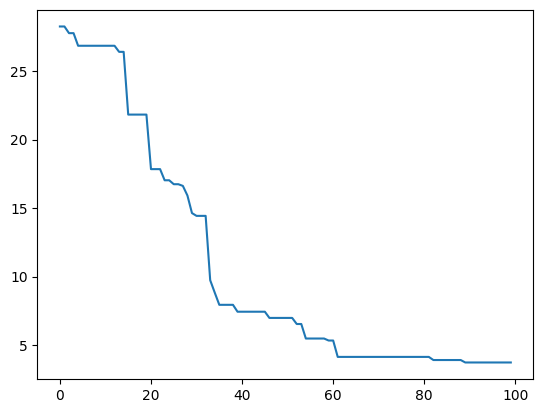

In [5]:
plt.plot(nn_model.fitness_curve[:,0])

In [ ]:
skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=True)
data = {
    'lr': LR,
    'alg': ALG,
    'max_attempts': MAX_ATTEMPTS,
    'clip': CLIP,
    'hidden_nodes': HIDDEN_NODES,
    'runs': [],
    'max_patience': MAX_PATIENCE,
}
for run_i, (train_index, test_index) in enumerate(skf.split(X, y)):
    start_time = time.perf_counter()

    run_data = {}

    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    y_train_one_hot = y_one_hot[train_index]
    y_test_one_hot = y_one_hot[test_index]

    iter_list = np.arange(1, 100001, 5) 
    test_scores = []
    best_test_score = 0
    patience_counter = 0
    for iterations in tqdm(iter_list):
        nn_model = NeuralNetwork(
            hidden_nodes=HIDDEN_NODES, activation='relu', 
            algorithm=ALG, 
            max_iters=iterations, bias=True, is_classifier=True, 
            learning_rate=LR, early_stopping=True, clip_max=CLIP, max_attempts=MAX_ATTEMPTS, 
            pop_size=POPULATION_SIZE, mutation_prob=MUTATION_RATE,
            random_state=run_i, curve=True
        )
        nn_model.fit(X_train, y_train_one_hot)
        score = nn_model.score(X_test, y_test_one_hot)
        test_scores.append(score)

        # early stopping
        if score > best_test_score:
            best_test_score = score
            patience_counter = 0
            print(f'New best test score: {best_test_score}')
        else:
            patience_counter += 1
            print(f'Patience: {patience_counter}, Test score: {score}')
            if patience_counter > MAX_PATIENCE:
                print("Early stopping at ", iterations)
                break

        if len(nn_model.fitness_curve) < iterations:
            print("Early stopping at ", iterations)
            break
    print(test_scores)
    end_time = time.perf_counter()
    run_data['test_scores'] = test_scores
    run_data['iterations'] = iter_list[:len(test_scores)]
    run_data['fitness_curve'] = nn_model.fitness_curve
    run_data['runtime'] = end_time - start_time

    data['runs'].append(run_data)

In [ ]:
path = f'metrics/{ALG}/{ALG}_pop_size{POPULATION_SIZE}_mut_rate{MUTATION_RATE}_pat{MAX_PATIENCE}_lr{LR}_clip{CLIP}_max_attempts{MAX_ATTEMPTS}_hidden_nodes{HIDDEN_NODES}.pkl'
os.makedirs(os.path.dirname(path), exist_ok=True)
pickle.dump(data, open(path, 'wb'))